In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.units as u
import treecorr
from pathlib import Path
import shapely
import shapely.geometry as sg
from itertools import combinations

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
patches_file = "../data/patches/patch_centers.npy"
patch_centers = np.load(patches_file)

exposure_path = lambda ind: f"../exposures/optic_shapes{ind:01d}.fits"

date = "20230705"
out_dir = f"../out/{date}_patches/"
plot_dir = f"../figs/{date}_patches/"
Path(plot_dir).mkdir(parents=True, exist_ok=True)
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [3]:
# load exposures one by one, dither them by the patch center and add them to the same catalog

x, y, g1, g2 = np.array([]), np.array([]), np.array([]), np.array([])

for ind in range(len(patch_centers)):
    with fits.open(exposure_path(ind)) as hdul:
        data = hdul[1].data
        x = np.append(x, data['x'] + patch_centers[ind][0]*u.deg.to(u.arcsec))
        y = np.append(y, data['y'] + patch_centers[ind][1]*u.deg.to(u.arcsec))
        g1 = np.append(g1, data['g1'])
        g2 = np.append(g2, data['g2'])

combined_cat = treecorr.Catalog(x=x, y=y, g1=g1, g2=g2, x_units='arcsec', y_units='arcsec')

In [4]:
len(combined_cat.x)

150000

In [5]:
gammas = g1 + 1j*g2

def getLineParameters(xpos, ypos, gamma):
    length, angle = np.abs(gamma), np.angle(gamma)
    return [xpos - np.cos(angle)*length/2, xpos + np.cos(angle)*length/2], \
            [ypos - np.sin(angle)*length/2, ypos + np.sin(angle)*length/2]

conversion_factor = (1*u.arcsec/u.degree).to("").value
RA_vals, Dec_vals = x * conversion_factor, y * conversion_factor
coords = np.vstack((RA_vals, Dec_vals, gammas)).T
np.random.shuffle(coords)

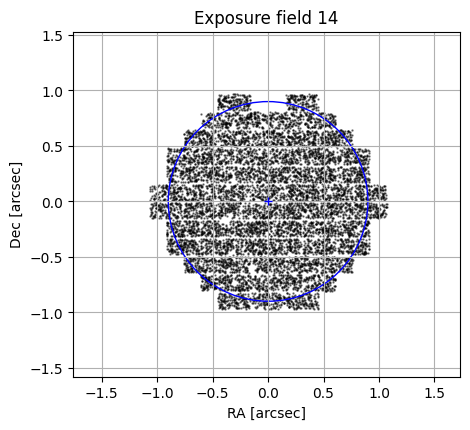

In [6]:
# plot one exposure field and one patch circle using sg
scaling_factor = 2
one_patch_rad=0.9*u.deg
plot_margin = 0.2

with fits.open(exposure_path(0)) as hdul:
    x, y = hdul[1].data['x']* conversion_factor, hdul[1].data['y'] * conversion_factor
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y, s=0.5, c='k', alpha=0.5)
ax.set_xlim([np.nanmin(RA_vals) - plot_margin, np.nanmax(RA_vals) + plot_margin])
ax.set_ylim([np.nanmin(Dec_vals) - plot_margin, np.nanmax(Dec_vals) + plot_margin])
ax.set_aspect('equal')
ax.grid()
ax.set_xlabel("RA [arcsec]")
ax.set_ylabel("Dec [arcsec]")
ax.set_title(f"Exposure field {ind}")

circle = plt.Circle((0, 0), one_patch_rad.to_value(u.deg), \
                        color='b', fill=False)
ax.add_artist(circle)
ax.plot(0, 0, 'b+')

plt.show()
plt.close()

/global/cfs/cdirs/des/shubh/.conda/envs/aber/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


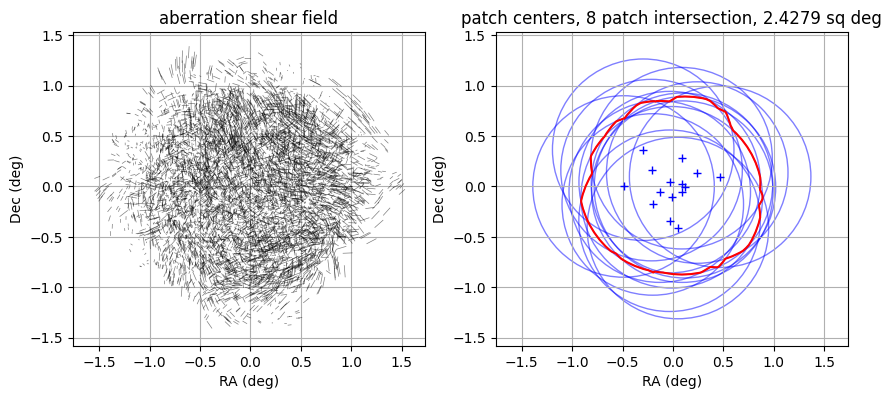

In [7]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for ra, de, gam in coords[::20]:
    ax1.plot(*getLineParameters(ra, de, gam*scaling_factor), \
                color="black", lw=0.5, alpha = 0.5)
    
geometries = []
for patch_center in patch_centers:
    geometries += [sg.Point(patch_center[0], \
                            patch_center[1]).buffer(one_patch_rad.to_value(u.deg))]
    circle = plt.Circle(patch_center, one_patch_rad.to_value(u.deg), \
                        color='b', fill=False, alpha=0.5)
    ax2.add_artist(circle)
    ax2.plot(patch_center[0], patch_center[1], 'b+')

inters = []
for comb in combinations(geometries, 8):
    inters += [shapely.intersection_all(comb)]
intersection = shapely.union_all(inters)
ax2.plot(*intersection.exterior.xy, 'r-')

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.set_xlim([np.nanmin(RA_vals) - plot_margin, np.nanmax(RA_vals) + plot_margin])
    ax.set_ylim([np.nanmin(Dec_vals) - plot_margin, np.nanmax(Dec_vals) + plot_margin])
    ax.grid()
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
ax1.set_title("aberration shear field")
ax2.set_title(f"patch centers, 8 patch intersection, {intersection.area:.4f} sq deg")
plt.savefig(plot_dir + "aberration_shear_field.png", dpi=300)
plt.show()
plt.close()

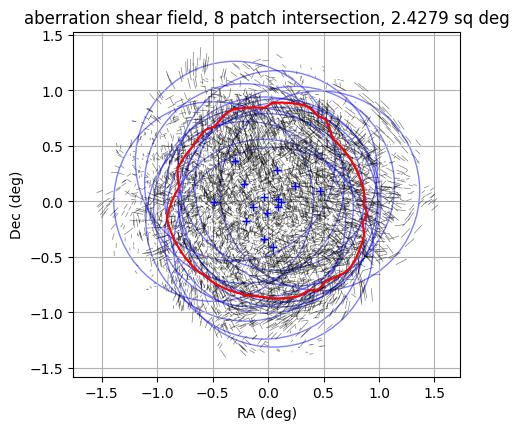

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
for ra, de, gam in coords[::20]:
    ax.plot(*getLineParameters(ra, de, gam*scaling_factor), \
                color="black", lw=0.5, alpha = 0.5)
    
geometries = []
for patch_center in patch_centers:
    geometries += [sg.Point(patch_center[0], \
                            patch_center[1]).buffer(one_patch_rad.to_value(u.deg))]
    circle = plt.Circle(patch_center, one_patch_rad.to_value(u.deg), \
                        color='b', fill=False, alpha=0.5)
    ax.add_artist(circle)
    ax.plot(patch_center[0], patch_center[1], 'b+')

inters = []
for comb in combinations(geometries, 8):
    inters += [shapely.intersection_all(comb)]
intersection = shapely.union_all(inters)
ax.plot(*intersection.exterior.xy, 'r-')

ax.set_aspect('equal')
ax.set_xlim([np.nanmin(RA_vals) - plot_margin, np.nanmax(RA_vals) + plot_margin])
ax.set_ylim([np.nanmin(Dec_vals) - plot_margin, np.nanmax(Dec_vals) + plot_margin])
ax.grid()
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title(f"aberration shear field, 8 patch intersection, {intersection.area:.4f} sq deg")
plt.savefig(plot_dir + "aberration_shear_field_combined.png", dpi=300)
plt.show()
plt.close()

In [9]:
rmin = 0.5
rmax = 20
nr = 10

narrow = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.0, max_u=1, nubins=20,
              min_v=0.0, max_v=0.1, nvbins=1, verbose=2, output_dots=True)
wide = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
            min_u=0.9, max_u=1, nubins=1,
            min_v=0.0, max_v=0.8, nvbins=20, verbose=2, output_dots=True)
wider = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
             min_u=0.9, max_u=1, nubins=1,
             min_v=0.8, max_v=0.95, nvbins=20, verbose=2, output_dots=True)
widest = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.9, max_u=1, nubins=1,
              min_v=0.95, max_v=1.0, nvbins=20, verbose=2, output_dots=True)

In [10]:
print("narrow")
ggg1 = treecorr.GGGCorrelation(narrow)
try:
    ggg1.read(out_dir + 'narrow.hdf')
except:
    ggg1.process(combined_cat, comm=comm)
    ggg1.write(out_dir + 'narrow.hdf', write_patch_results=True)

print("wide")
ggg2 = treecorr.GGGCorrelation(wide)
try:
    ggg2.read(out_dir + 'wide.hdf')
except:
    ggg2.process(combined_cat, comm=comm)
    ggg2.write(out_dir + 'wide.hdf', write_patch_results=True)

print("wider")
ggg3 = treecorr.GGGCorrelation(wider)
try:
    ggg3.read(out_dir + 'wider.hdf')
except:
    ggg3.process(combined_cat, comm=comm)
    ggg3.write(out_dir + 'wider.hdf', write_patch_results=True)

print("widest")
ggg4 = treecorr.GGGCorrelation(widest)
try:
    ggg4.read(out_dir + 'widest.hdf')
except:
    ggg4.process(combined_cat, comm=comm)
    ggg4.write(out_dir + 'widest.hdf', write_patch_results=True)

narrow
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 20, min,max = 0..1, bin_size = 0.05
v: nbins = 1, min,max = 0..0.1, bin_size = 0.1
Reading GGG correlations from ../out/20230705_patches/narrow.hdf
   file_type assumed to be HDF from the file name.
wide
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0..0.8, bin_size = 0.04
Reading GGG correlations from ../out/20230705_patches/wide.hdf
   file_type assumed to be HDF from the file name.
wider
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0.8..0.95, bin_size = 0.0075
Reading GGG correlations from ../out/20230705_patches/wider.hdf
   file_type assumed to be HDF from the file name.
widest
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0.95..1

In [11]:
g_ttt_func = lambda ggg: -0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_txx_func = lambda ggg: -0.25 * (- ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_xtx_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).real
g_xxt_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).real
g_ttx_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).imag
g_txt_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).imag
g_xtt_func = lambda ggg: 0.25 * (ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).imag
g_xxx_func = lambda ggg: 0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).imag

def var_func(ggg):
    return 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

def get_gamma_func(g_func, var_func):
    all_g_ttt = []
    all_sig_ttt = []
    all_meanr = []
    all_phi = []

    for ggg in [ggg1, ggg2, ggg3, ggg4]:

        g_ttt = g_func(ggg)
        var_ttt = var_func(ggg)

        _nr, nu, nv = g_ttt.shape
        assert _nr == nr
        assert nv % 2 == 0
        nv //= 2
        assert nu == 1 or nv == 1

        d1 = ggg.meand1
        d2 = ggg.meand2
        d3 = ggg.meand3
        if nu == 1:
            # if nu==1, then u=1, so d2 = d3, and phi is between d2 and d3
            phi = np.arccos( (d2**2 + d3**2 - d1**2) / (2*d2*d3) )
            meanr = np.array([np.mean([d2[ir], d3[ir]]) for ir in range(nr)])
        else:
            # if nv==1, then v=0, so d1 = d2, and phi is between d1 and d2
            phi = np.arccos( (d1**2 + d2**2 - d3**2) / (2*d1*d2) )
            meanr = np.array([np.mean([d1[ir], d2[ir]]) for ir in range(nr)])
        phi *= 180/np.pi

        # We don't care about v>0 vs v<0, so combine them.
        phi = (phi[:,:,nv-1::-1] + phi[:,:,nv:]) / 2
        g_ttt = (g_ttt[:,:,nv-1::-1] + g_ttt[:,:,nv:]) / 2
        var_ttt = (var_ttt[:,:,nv-1::-1] + var_ttt[:,:,nv:]) / 4
        sig_ttt = var_ttt**0.5

        # print('shapes:')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)
        # print('meanr: ',meanr.shape)

        # print('meanr =  ',meanr)

        if nu == 1:
            phi = phi[:,0,:]
            g_ttt = g_ttt[:,0,:]
            sig_ttt = sig_ttt[:,0,:]
        else:
            phi = phi[:,:,0]
            g_ttt = g_ttt[:,:,0]
            sig_ttt = sig_ttt[:,:,0]

        # print('shapes ->')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)

        all_phi.append(phi)
        all_g_ttt.append(g_ttt)
        all_sig_ttt.append(sig_ttt)
        all_meanr.append(meanr)

    phi = np.concatenate(all_phi, axis=1)
    g_ttt = np.concatenate(all_g_ttt, axis=1)
    sig_ttt = np.concatenate(all_sig_ttt, axis=1)
    meanr = np.concatenate(all_meanr, axis=0)
    
    return phi, g_ttt, sig_ttt, meanr

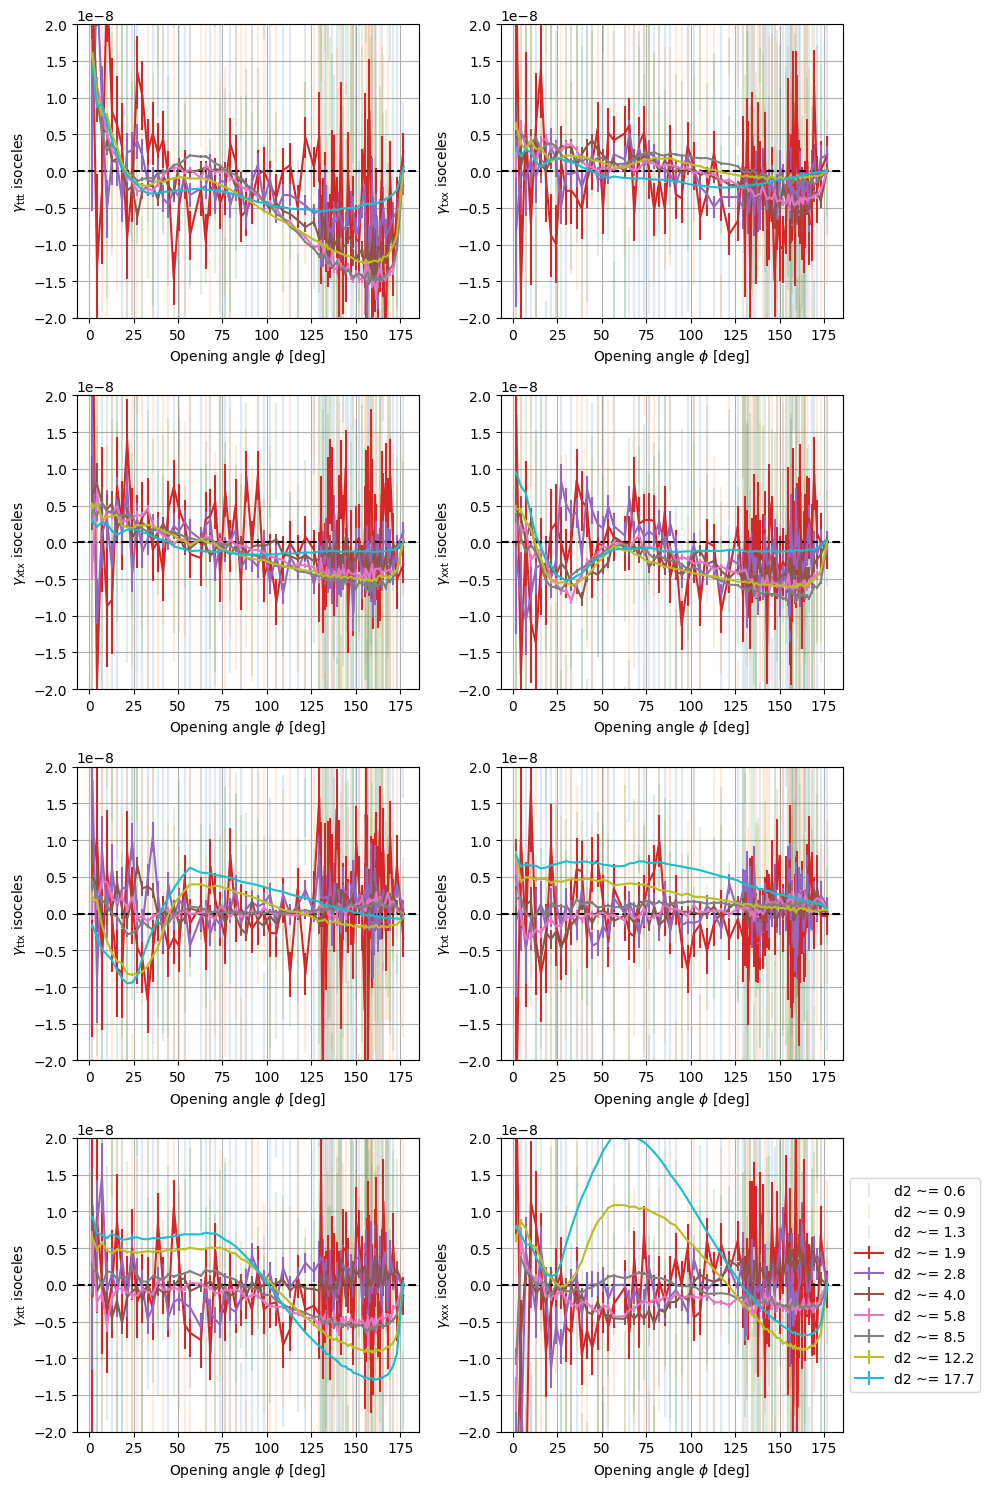

In [24]:
g_funcs = [g_ttt_func, g_txx_func, g_xtx_func, g_xxt_func, g_ttx_func, g_txt_func, g_xtt_func, g_xxx_func]
labels = ["{\\rm ttt}", "{\\rm txx}", "{\\rm xtx}", "{\\rm xxt}", "{\\rm ttx}", "{\\rm txt}", "{\\rm xtt}", "{\\rm xxx}"]

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for label, g_func, ax in zip(labels, g_funcs, axs.ravel()):
    
    phi, g_txx, sig_txx, meanr = get_gamma_func(g_func, var_func)
    lines = []
    for ir in range(nr)[:3]:
        line = ax.errorbar(phi[ir], g_txx[ir], sig_txx[ir], alpha=0.15, ls='None')
        lines.append((line, 'd2 ~= %.1f'%meanr[ir]))
    for ir in range(nr)[3:]:
        line = ax.errorbar(phi[ir], g_txx[ir], sig_txx[ir])
        lines.append((line, 'd2 ~= %.1f'%meanr[ir]))
    ax.set_xlabel(r'Opening angle $\phi$ [deg]')
    ax.set_ylabel(r'$\gamma_{}$ isoceles'.format(label))
    ax.set_ylim([-2e-8, 2e-8])
    fig.set_tight_layout(True)
    ax.grid()
    ax.axhline(y=0, ls="--", color="black")
plt.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(plot_dir + "3pt_zoom.png", dpi=300)
plt.show()
plt.close()